<a href="https://colab.research.google.com/github/emran-bigdeli/Modified-HRP/blob/main/Modified-HRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install portfoliolab


In [2]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd

def getIVP(cov,**kargs):
  # Compute the inverse-variance portfolio
  ivp=1./np.diag(cov)
  ivp/=ivp.sum()
  return ivp
def getClusterVar(cov,cItems):
  # Compute variance per cluster
  cov_=cov.loc[cItems,cItems] # matrix slice
  w_=getIVP(cov_).reshape(-1,1) #make a vector of porfolio weights
  cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0] #compute variance simply
  return cVar
def getQuasiDiag(link):
  # Sort clustered items by distance
  link=link.astype(int) 
  sortIx=pd.Series([link[-1,0],link[-1,1]])
  numItems=link[-1,3] # number of original items
  
  while sortIx.max()>=numItems:
    sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
    df0=sortIx[sortIx>=numItems] # find clusters 
    i=df0.index; j=df0.values-numItems
    sortIx[i]=link[j,0] # item 1
    df0=pd.Series(link[j,1],index=i+1)
    sortIx=sortIx.append(df0) # item 2
    sortIx=sortIx.sort_index() # re-sort
    sortIx.index=range(sortIx.shape[0]) # re-index
    
  return sortIx.tolist()

def getRecBipart(cov,sortIx):
# Compute HRP alloc
  w=pd.Series(1,index=sortIx)
  cItems=[sortIx] # initialize all items in one cluster
  while len(cItems)>0:
    cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)//2), (len(i)//2,len(i))) if len(i)>1] # bi-section
    #print(cItems)
    for i in range(0,len(cItems),2): # parse in pairs
      cItems0=cItems[i] # cluster 1
      cItems1=cItems[i+1] # cluster 2
      cVar0=getClusterVar(cov,cItems0)
      cVar1=getClusterVar(cov,cItems1)
      alpha=1-cVar0/(cVar0+cVar1)
      w[cItems0]*=alpha # weight 1
      w[cItems1]*=1-alpha # weight 2
  return w
def correlDist(corr):
  # A distance matrix based on correlation, where 0<=d[i,j]<=1
  # This is a proper distance metric
  dist=((1-corr)/2.)**.5 # distance matrix
  return dist
def plotCorrMatrix(path,corr,labels=None):
  # Heatmap of the correlation matrix
  if labels is None:labels=[]
  mpl.pcolor(corr)
  mpl.colorbar()
  mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
  mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
  mpl.savefig(path)
  mpl.clf();mpl.close() # reset pylab
  return
def generateData(nObs,size0,size1,sigma1):
  # Time series of correlated variables
  #1) generating some uncorrelated data
  np.random.seed(seed=12345);random.seed(12345)
  x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable

  cols=[random.randint(0,(size0 - 1)) for i in range(size1)]
  y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
  x=np.append(x,y,axis=1)
  x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
  return x,cols


#1) Generate correlated data
nObs,size0,size1,sigma1=10000,5,5,.25
x,cols = generateData(nObs,size0,size1,sigma1)
#print [(j+1,size0+i) for i,j in enumerate(cols,1)]
cov,corr=x.cov(),x.corr()
#2) compute and plot correl matrix
plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
#3) cluster
dist=correlDist(corr)
link=sch.linkage(dist,'single')
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist() # recover labels
df0=corr.loc[sortIx,sortIx] # reorder
plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
#4) Capital allocation
hrp=getRecBipart(cov,sortIx)
print (hrp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


8     0.071408
3     0.075961
9     0.125317
2     0.067596
10    0.063236
1     0.109945
7     0.103968
5     0.193357
4     0.097549
6     0.091662
dtype: float64


In [3]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
All_Crypto=pd.DataFrame()
Crypto_list= ['BTC-USD', 'ETH-USD', 'LTC-USD', 'BNB-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'SOL1-USD', 'HEX-USD', 'DOT1-USD']
for symb in Crypto_list:
    data= pd.DataFrame(yf.Ticker(symb).history(start="2019-01-01", end="2021-08-08")['Close']).transpose()
    data.to_csv(symb + '.csv')
    if symb == 'BTC-USD':
      All_Crypto = data.copy()
    else:
      All_Crypto=All_Crypto.append(data)
All_Crypto.index=[Crypto_list]
All_Crypto=All_Crypto.transpose()
All_Crypto = All_Crypto.pct_change(1)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


(HEX-USD,)      1.056327
(DOGE-USD,)     6.783274
(SOL1-USD,)     9.466961
(DOT1-USD,)     7.026176
(XRP-USD,)     12.155632
(BNB-USD,)     12.378345
(ADA-USD,)     12.835165
(BTC-USD,)     23.643790
(ETH-USD,)      7.873415
(LTC-USD,)      6.780916
dtype: float64


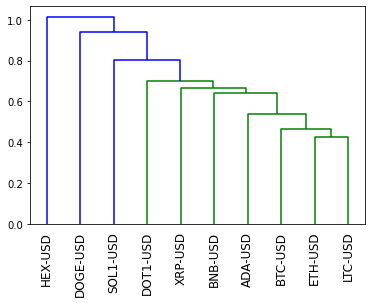

In [4]:
cov,corr=All_Crypto.cov(),All_Crypto.corr()
#2) compute and plot correl matrix
plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
#3) cluster
dist=correlDist(corr)
link=sch.linkage(dist,'single')
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist() # recover labels
df0=corr.loc[sortIx,sortIx] # reorder
plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
#4) Capital allocation
hrp=getRecBipart(cov,sortIx)
print (hrp*100)
def llf(id):
    for i in range(10):
      if i == id:
        return Crypto_list[i]
sch.dendrogram(link,leaf_label_func=llf, leaf_rotation=90 )
mpl.show()

In [ ]:
print(All_Crypto)

             BTC-USD   ETH-USD   LTC-USD  ...  SOL1-USD   HEX-USD  DOT1-USD
Date                                      ...                              
2019-01-01       NaN       NaN       NaN  ...       NaN       NaN       NaN
2019-01-02  0.025989  0.101039  0.045458  ...       NaN       NaN       NaN
2019-01-03 -0.027050 -0.038135 -0.042083  ...       NaN       NaN       NaN
2019-01-04  0.005467  0.036523  0.011786  ...       NaN       NaN       NaN
2019-01-05 -0.003246  0.006836  0.078160  ...       NaN       NaN       NaN
...              ...       ...       ...  ...       ...       ...       ...
2021-08-04  0.041793  0.088825  0.031327  ...  0.051981  0.033584  0.105340
2021-08-05  0.028229  0.037697  0.005700  ...  0.044501 -0.007296 -0.001603
2021-08-06  0.047638  0.022499  0.030432  ...  0.055975 -0.071364  0.066291
2021-08-07  0.040622  0.092114  0.054559  ... -0.001081 -0.051321  0.027765
2021-08-08 -0.017005 -0.045453 -0.038604  ... -0.043896  0.019239 -0.061571

[947 rows x

In [ ]:

from portfoliolab.modern_portfolio_theory import CriticalLineAlgorithm
cla = CriticalLineAlgorithm()
cla.allocate(asset_prices=All_Crypto, solution='max_sharpe')
cla_weights = cla.weights.sort_values(by=0, ascending=False, axis=1)
max_sharpe_value = cla.max_sharpe # Accessing the max sharpe value
print(cla_weights.transpose())


                 0
SOL1-USD  0.416377
DOT1-USD  0.195575
DOGE-USD  0.148496
HEX-USD   0.112164
BNB-USD   0.085837
ADA-USD   0.027471
BTC-USD   0.014081
ETH-USD   0.000000
LTC-USD   0.000000
XRP-USD   0.000000


In [ ]:
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd
from portfoliolab.modern_portfolio_theory import CriticalLineAlgorithm
def generateData(nObs,sLength,size0,size1,mu0,sigma0,sigma1F):
  # Time series of correlated variables
  #1) generate random uncorrelated data
  x=np.random.normal(mu0,sigma0,size=(nObs,size0))
  #2) create correlation between the variables
  cols=[random.randint(0,size0 - 1) for i in range(size1)]
  y=x[:,cols]+np.random.normal(0,sigma0*sigma1F,size=(nObs,len(cols)))
  x=np.append(x,y,axis=1)
  #3) add common random shock
  point=np.random.randint(sLength,nObs-1,size=2)
  x[np.ix_(point,[cols[0],size0])]=np.array([[-.5,-.5],[2,2]])
  #4) add specific random shock
  point=np.random.randint(sLength,nObs-1,size=2)
  x[point,cols[-1]]=np.array([-.5,2])
  return x,cols


def getHRP(cov,corr):
  # Construct a hierarchical portfolio
  corr,cov=pd.DataFrame(corr),pd.DataFrame(cov)
  dist=correlDist(corr)
  link=sch.linkage(dist,'single')
  sortIx=getQuasiDiag(link)
  sortIx=corr.index[sortIx].tolist() # recover labels
  hrp=getRecBipart(cov,sortIx)
  return hrp.sort_index()


def getCLA(cov,**kargs):
  # Compute CLA's minimum variance portfolio
  mean=np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
  lB=range(mean.shape[0])
  #uB=np.ones(mean.shape)
  #cla=CLA(mean,cov,lB,uB)
  #cla.solve()
  cla = CriticalLineAlgorithm()
  cla.allocate(covariance_matrix=cov,expected_asset_returns=mean, asset_names=lB , solution='max_sharpe')
  cla_weights = cla.weights.sort_values(by=0, ascending=False, axis=1)
  max_sharpe_value = cla.max_sharpe # Accessing the max sharpe value
  return cla_weights


numIters=1
nObs=520
size0=5
size1=5
mu0=0
sigma0=1e-2
sigma1F=.25
sLength=260
rebal=22
# Monte Carlo experiment on HRP
methods=[getIVP,getHRP,getCLA]
stats,numIter={i.__name__:pd.Series() for i in methods},0
pointers=range(sLength,nObs,rebal)
while numIter<numIters:
  #print (numIter)
  #1) Prepare data for one experiment
  x,cols=generateData(nObs,sLength,size0,size1,mu0,sigma0,sigma1F)
  r={i.__name__:pd.Series() for i in methods}
  #2) Compute portfolios in-sample
  for pointer in pointers:
    x_=x[pointer-sLength:pointer]
    cov_,corr_=np.cov(x_,rowvar=0),np.corrcoef(x_,rowvar=0)
    #3) Compute performance out-of-sample
    x_=x[pointer:pointer+rebal]
    for func in methods:
      if func==getCLA:
        w_=getCLA(cov_)# callback
        r_=x_ @ (w_.transpose())
        r_=r_.iloc[0]
        r[func.__name__]=r[func.__name__].append(r_)
      else:
        w_=func(cov=cov_,corr=corr_) # callback
        r_=pd.Series(x_ @ (w_.transpose()))
        r[func.__name__]=r[func.__name__].append(r_)
  #4) Evaluate and store results
  for func in methods:
    r_=r[func.__name__].reset_index(drop=True)
    p_=(1+r_).cumprod()
    stats[func.__name__].loc[numIter]=p_.iloc[-1]-1
  numIter+=1
#5) Report results
stats=pd.DataFrame.from_dict(stats,orient='columns')
stats.to_csv('stats.csv')
from google.colab import files
files.download("stats.csv")
df0,df1=stats.std(),stats.var()
print (pd.concat([df0,df1,df1/df1['getHRP']-1],axis=1))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         0   1   2
getIVP NaN NaN NaN
getHRP NaN NaN NaN
getCLA NaN NaN NaN


In [ ]:
covmov=All_Crypto.cov()
print(covmov)
print(All_Crypto)

               BTC-USD       ETH-USD  ...     HEX-USD       DOT1-USD
BTC-USD   2.527084e+08  1.234266e+07  ...  386.451763  196358.371246
ETH-USD   1.234266e+07  7.288759e+05  ...   30.381658    9504.148316
LTC-USD   9.118202e+05  4.786484e+04  ...    1.406899     881.832814
BNB-USD   1.952214e+06  1.152947e+05  ...    4.440305    1966.885297
ADA-USD   7.088772e+03  4.185619e+02  ...    0.018714       6.191596
XRP-USD   3.379980e+03  2.068744e+02  ...    0.007368       3.404243
DOGE-USD  1.126679e+03  8.087298e+01  ...    0.003560       1.046051
SOL1-USD  1.856705e+05  1.376914e+04  ...    0.498392     125.353866
HEX-USD   3.864518e+02  3.038166e+01  ...    0.001532      -0.010033
DOT1-USD  1.963584e+05  9.504148e+03  ...   -0.010033     171.539521

[10 rows x 10 columns]
                 BTC-USD      ETH-USD  ...   HEX-USD   DOT1-USD
Date                                   ...                     
2019-01-01   3843.520020   140.819412  ...       NaN        NaN
2019-01-02   3943.409424 

In [ ]:

methods=[getIVP,getHRP,getCLA]
sLength=180
obs=360
rebal=30
pointers=range(sLength,obs,rebal)
r={i.__name__:pd.Series() for i in methods}
#2) Compute portfolios in-sample
for pointer in pointers:
  x_=All_Crypto[pointer-sLength:pointer]
  cov_,corr_=All_Crypto.cov(),All_Crypto.corr()
  #3) Compute performance out-of-sample
  x_=All_Crypto[pointer:pointer+rebal]
  x_=x_.fillna(0)
  x_=x_.values
  print(type(x_))
  for func in methods:
    if func==getCLA:
      w_=getCLA(cov_.values).iloc[0]# callback
      r_=pd.Series(x_ @ (w_.transpose()))
      #print(r_.shape)
      #r_=r_.iloc[0]
      r[func.__name__]=r[func.__name__].append(r_)
    else:
      w_=func(cov=cov_,corr=corr_) # callback
      
      r_=pd.Series(x_ @ (w_.transpose()))
      #print(r_)
      r[func.__name__]=r[func.__name__].append(r_)
#4) Evaluate and store results
print(r)

for func in methods:
  r_=r[func.__name__].reset_index(drop=True)
  p_=(1+r_).cumprod()
  stats[func.__name__].loc[numIter]=p_.iloc[-1]-1
stats=pd.DataFrame.from_dict(stats,orient='columns')
stats.to_csv('stats.csv')
from google.colab import files
files.download("stats.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
{'getIVP': 0    -0.077941
1     0.002781
2    -0.007987
3     0.045095
4    -0.039988
        ...   
25    0.028872
26    0.002998
27    0.001757
28   -0.005935
29   -0.001169
Length: 180, dtype: float64, 'getHRP': 0    -0.062371
1     0.003614
2    -0.010235
3     0.030303
4    -0.028620
        ...   
25   -0.060520
26    0.617474
27   -0.034914
28    0.066938
29   -0.005562
Length: 180, dtype: float64, 'getCLA': 0    -0.091966
1    -0.006045
2     0.001369
3     0.069844
4    -0.050306
        ...   
25    0.041243
26   -0.025119
27   -0.000371
28   -0.010428
29   -0.003004
Length: 180, dtype: float64}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>